In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from scipy import ndimage
# import ipywidgets

%matplotlib notebook

In [2]:
@np.vectorize
def clip(x):
    if x > 0:
        return x
    return 0

@np.vectorize
def saturate(x):
    if x > 6:
        return 255
    return 0

@np.vectorize
def desaturate(x):
    if x > 245:
        return 0
    return x

In [3]:
folder = './B-ol13-aq15-fps1/'

images = []
for name in os.listdir(folder):
    if name.startswith('frames'):
        images.append(Image.open(folder + name))
        
arrays = np.array([np.asarray(image) for image in images])

mean_array = np.zeros_like(arrays[0],dtype=float)
for array in arrays:
    mean_array += array
mean_array /= (arrays.shape[0])

mean_array = np.array(mean_array,dtype=np.uint8)

In [4]:
for idx in range(len(arrays))[:10]:
# idx = 4

    array_sub = (arrays[idx] - mean_array + 25)*5

    Image.fromarray((array_sub[:,:,:])).show()

In [104]:
# gaussian filter
idx = 4
array_sub = (arrays[idx] - mean_array + 25)*5
array_filtered = ndimage.gaussian_filter(array_sub,3)

Image.fromarray((array_sub[:,:,:])).show()
Image.fromarray((array_filtered[:,:,:])).show()

### Masking

In [5]:
def make_mask(shape,func):
    mask = np.zeros(shape,dtype=np.uint8)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if func(i,j) > 0:
                mask[i,j] = 1
    return mask

In [50]:
def line1(i,j):
    return i - 0.7*j - 50

def line2(i,j):
    return -i + 0.7*j + 150

mask1 = make_mask((960,1280),line1)
mask2 = make_mask((960,1280),line2)

mask = mask1*mask2

In [59]:
np.uint8(10) - np.uint8(20)

<ipython-input-59-7fc352225e93>:1: RuntimeWarning: overflow encountered in ubyte_scalars
  np.uint8(10) - np.uint8(20)


246

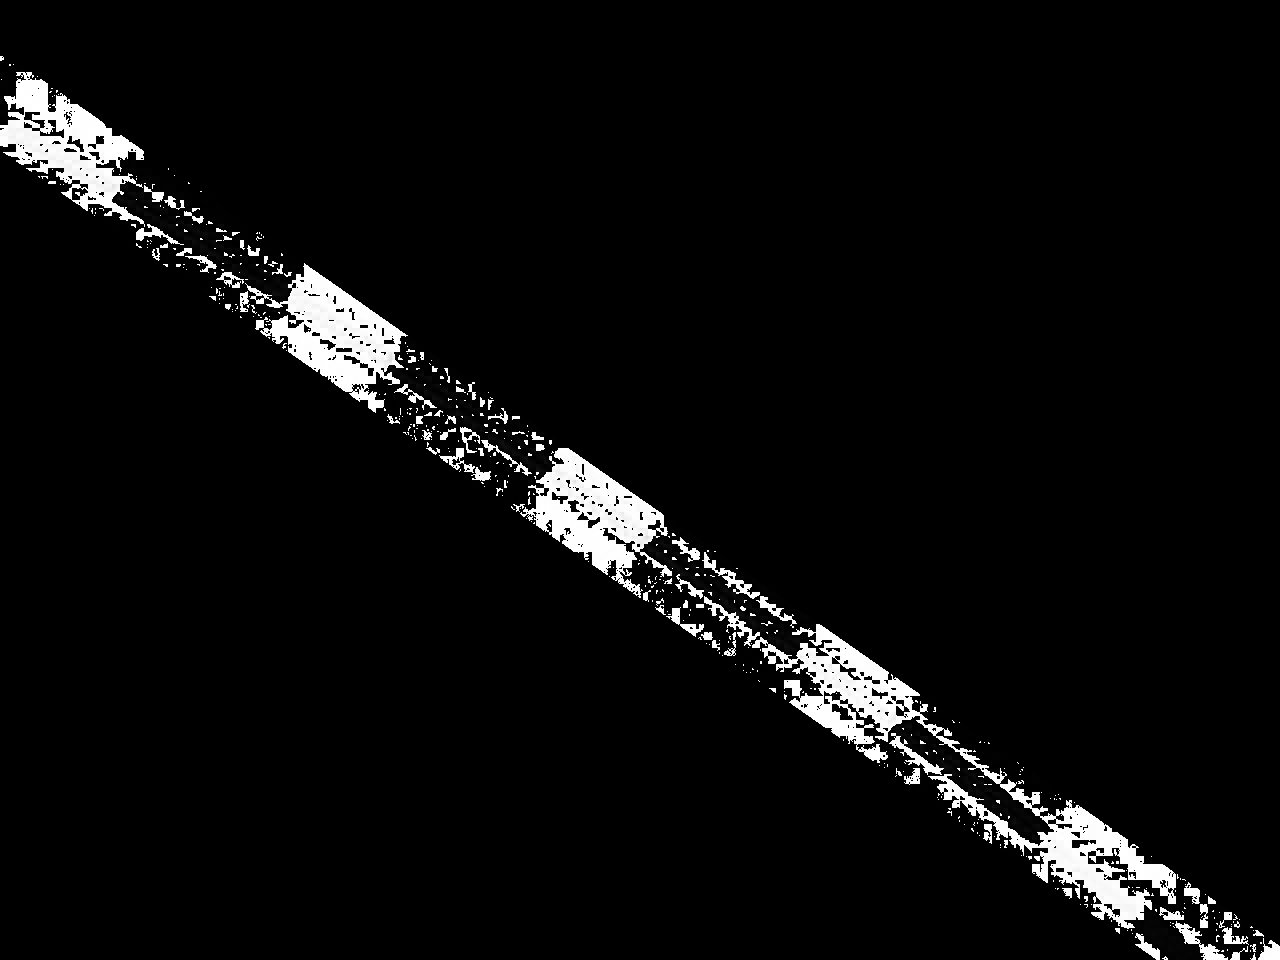

In [65]:
Image.fromarray((mean_array - arrays[17])[:,:,1]*mask)#.rotate(35)

In [4]:
# extend and rotate

def extend(array, new_shape=(960,1600)):
    new_array = np.zeros(new_shape,dtype=np.uint8)
    offset_x = (new_shape[0] - array.shape[0])//2
    offset_y = (new_shape[1] - array.shape[1])//2
    
    new_array[offset_x:(offset_x + array.shape[0]), offset_y:(offset_y + array.shape[1])] = array
    return new_array

In [105]:
Image.fromarray(arrays[0][:,:,1]).show()
Image.fromarray(extend(arrays[0][:,:,1])).rotate(35).show()

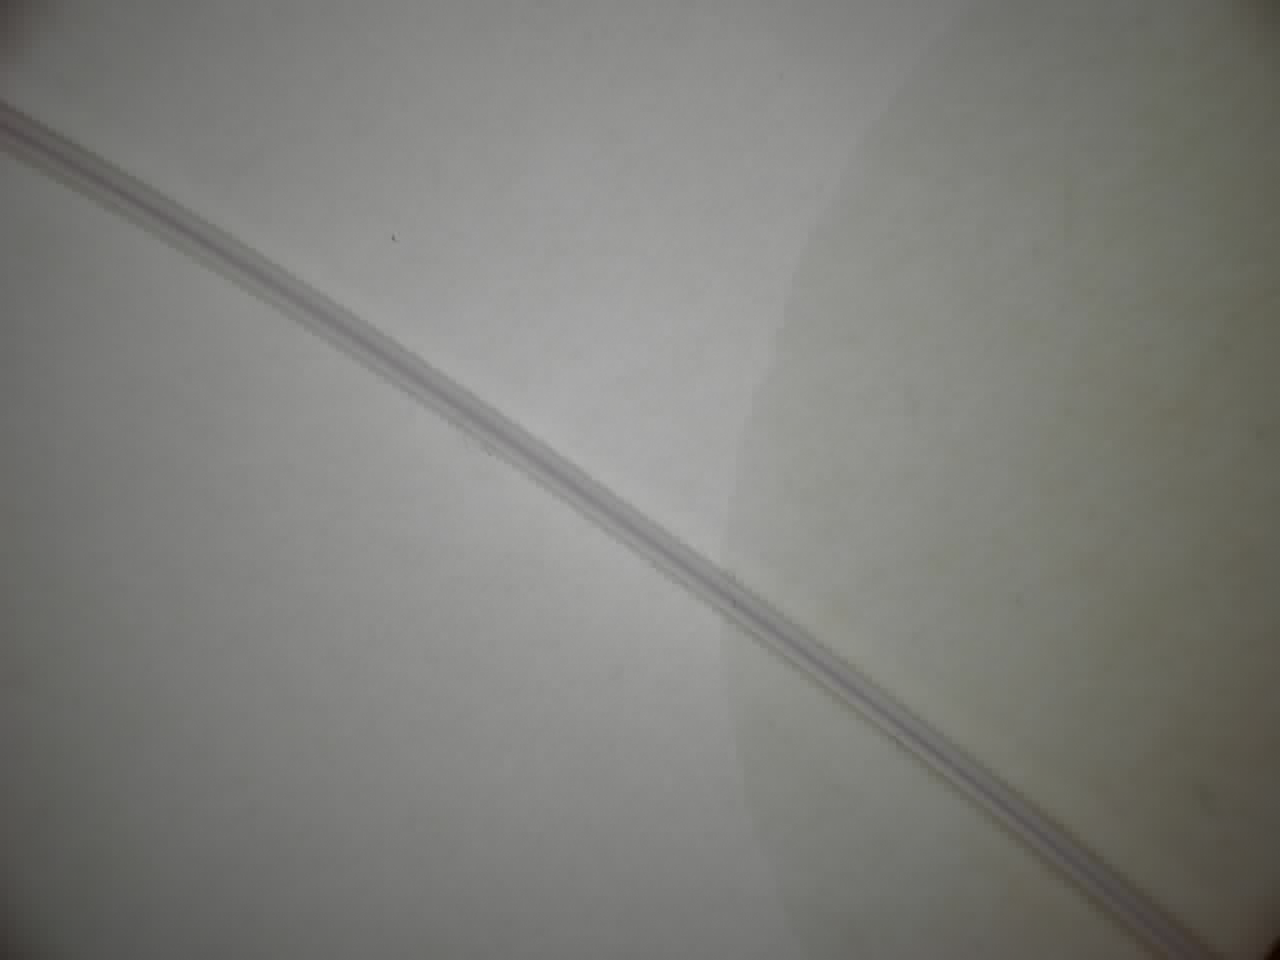

In [55]:
Image.fromarray(desaturate(np.array(mean_array,dtype=np.uint8)))

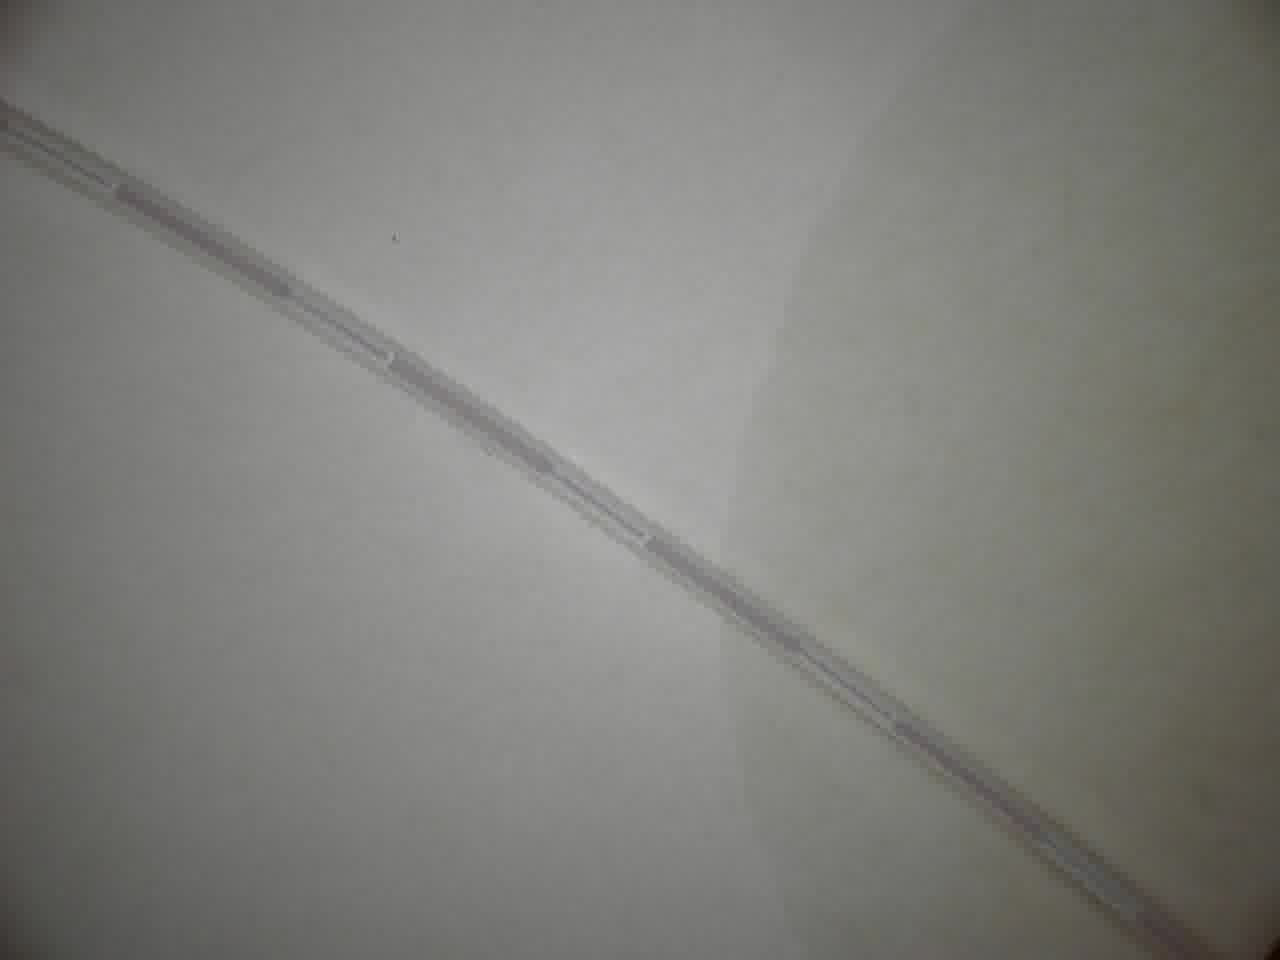

In [7]:
Image.fromarray((arrays[17]))

## Do everything

In [5]:
idx = 4

input_array = arrays[idx]

# subtract mean
array_sub = (arrays[idx] - mean_array + 25)*5

# extend and rotate
img = Image.fromarray(extend(array_sub[:,:,1])).rotate(35)

array = np.asarray(img)

In [26]:
class channel_analyzer():
    
    def __init__(self):
        
        # for isolating the channel
        self.points = []
        self.thickness = 10
        
        # variables for plotting
        self.points_on_ax = None
        self.highlight_on_ax = None
        self.u_border_on_ax = None
        self.l_border_on_ax = None
        self.shown_borders = False
        self.sorted_points = True
        
        self.current_index = -1
        
        # for calibrating the images
        self.real_distance = 0. # in mm
        self._c_constant = None
        self.c_points = []
        
        # variables for plotting
        self.c_points_on_ax = None
        self.c_highlight_on_ax = None
        self.c_current_index = -1
        
        # variables for analysis
        self._central_ys = None
        self._s = None
        
    @property
    def s(self):
        if self._s is None:
            self._s = []
            s_coord = 0.
            point_idx = 0
            x = self.points[0][0]
            dilation = 0.
            def compute_dilation():
                return np.sqrt((self.points[point_idx + 1][0] - self.points[point_idx][0])**2 + 
                                (self.points[point_idx + 1][1] - 
                                    self.points[point_idx][1])**2)/(self.points[point_idx + 1][0] -
                                                                    self.points[point_idx][0])
            dilation = compute_dilation()
            
            while(x < self.points[-1][0]):
                self._s.append(s_coord)
                s_coord += dilation
                if x == self.points[point_idx + 1][0]:
                    point_idx += 1
                    dilation = compute_dilation()
                x += 1
            # do the last point
            self._s.append(s_coord)
            
            self._s = np.array(self._s)
            self._s *= self.c_constant
            
        return self._s
    
    @property
    def central_ys(self):
        if self._central_ys is None:
            self._central_ys = []
            point_idx = 0
            x = self.points[0][0]
            def compute_inclination():
                return (self.points[point_idx + 1][1] - 
                        self.points[point_idx][1])/(self.points[point_idx + 1][0] - 
                                                    self.points[point_idx][0])
            inclination = compute_inclination()
            while(x < self.points[-1][0]):
                if x == self.points[point_idx + 1][0]:
                    point_idx += 1
                    inclination = compute_inclination()
                    y = self.points[point_idx][1]
                else:
                    y = self.points[point_idx][1] + int((x - self.points[point_idx][0])*inclination)
                self._central_ys.append(y)
                x += 1
            # do the last point
            y = self.points[-1][1]
            self._central_ys.append(y)
            
            self._central_ys = np.array(self._central_ys)
            
        return self._central_ys
            
            
    @property
    def c_constant(self): # calibration constant: from distance in pixels to distance in mm
        if self._c_constant is None:
            pixel_distance = np.sqrt((self.c_points[0][0] - self.c_points[1][0])**2 +
                                     (self.c_points[0][1] - self.c_points[1][1])**2)
            self._c_constant = self.real_distance/pixel_distance
        return self._c_constant
    
    
    def evaluate(self,img):
        '''
        Compute the behavior of the luminosity of the pixels along the channel
        
        Input:
            img: Image object
            
        Returns:
            s: array with the coordinate along the channel in mm
            mean: array with the mean luminosity
            std: array with the std of the luminosity
        '''
        array = np.asarray(img)
        
        mean = []
        std = []
        
        for i,y in enumerate(self.central_ys):
            x = self.points[0][0] + i
            a = array[y - self.thickness : y + self.thickness + 1, x] # first y then x
            mean.append(np.mean(a))
            std.append(np.std(a,ddof=1))
        
        mean = np.array(mean)
        std = np.array(std)
        
        return self.s, mean, std

        
    
    def calibrate(self,img,real_distance):
        '''
        Allows to calibrate the object to distances in mm
        
        Input:
            img: image with an object of known size
            real_distance: distance in mm between the two points you are going to put on the image
            
        Requirements:
            You need to have %matplotlib notebook
        
        Controls:
            Right click to add a point to the image. The selected one is highlighted in red
            Press:
                f: select next point
                z: remove selected point
                a, w, d, x: move selected point
                u: update the positions of the points
                
                o: zoom on image
                c: go back to previous view
                v: go forward to next view
                p: move the field of view in a zoomed view
        '''
        self.real_distance = real_distance
        
        fig, ax = plt.subplots()
        ax.imshow(img)
        
        def scatter_points():
            p = np.array(self.c_points)
            return ax.scatter(p[:,0],p[:,1],
                              marker='+',color='yellow')
        def highlight_point():
            self._c_constant = None
            return ax.scatter(self.c_points[self.c_current_index][0],self.c_points[self.c_current_index][1],
                              marker='+',color='red')
        
        def remove(obj):
            if obj:
                if obj.axes:
                    obj.remove()
        
        def onclick(event):
            
            if len(self.c_points) < 2:
                # works with right click
                if event.button == 3:
                    ix = int(event.xdata)
                    iy = int(event.ydata)

                    self.c_points.append([ix,iy])

                    #clear previous plots
                    remove(self.c_points_on_ax)
                    remove(self.c_highlight_on_ax)
                    self.c_points_on_ax = scatter_points()
                    self.c_current_index = len(self.c_points) - 1
                    self.c_highlight_on_ax = highlight_point()
            
        def onpress(event):
            
            # scroll points
            if event.key == 'f':
                self.c_current_index = (self.c_current_index + 1) % len(self.c_points)
                remove(self.c_highlight_on_ax)
                self.c_highlight_on_ax = highlight_point()
            
            # remove a point
            if event.key == 'z':
                remove(self.c_points_on_ax)
                remove(self.c_highlight_on_ax)
                _ = self.c_points.pop(self.c_current_index)
                self.c_points_on_ax = scatter_points()
                
            # move a point
                # left
            if event.key == 'a':
                remove(self.c_highlight_on_ax)
                self.c_points[self.c_current_index][0] -= 1
                self.c_highlight_on_ax = highlight_point()
                
                # right
            if event.key == 'd':
                remove(self.c_highlight_on_ax)
                self.c_points[self.c_current_index][0] += 1
                self.c_highlight_on_ax = highlight_point()
            
                # up
            if event.key == 'w':
                remove(self.c_highlight_on_ax)
                self.c_points[self.c_current_index][1] -= 1
                self.c_highlight_on_ax = highlight_point()
            
                # down
            if event.key == 'x':
                remove(self.c_highlight_on_ax)
                self.c_points[self.c_current_index][1] += 1
                self.c_highlight_on_ax = highlight_point()
                
            # update the points positions
            if event.key == 'u':
                remove(self.c_points_on_ax)
                self.c_points_on_ax = scatter_points()
                
                
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
        
    def find_channel(self,img):
        '''
        Allows to isolate the channel from the rest of the image
        
        Input:
            img: image with the channel
        
        Requirements:
            You need to have %matplotlib notebook
        
        Controls:
            Right click to add a point to the image. The selected one is highlighted in red
            Press:
                f: select next point
                z: remove selected point
                a, w, d, x: move selected point
                u: update the positions of the points
                
                b: to toggle the view of the channel the object will use for the analysis
                t: make the channel thicker if it is shown
                y: make the channel thinner if it is shown
                
                o: zoom on image
                c: go back to previous view
                v: go forward to next view
                p: move the field of view in a zoomed view
        '''
        fig, ax = plt.subplots()
        ax.imshow(img)
        
        def scatter_points():
            p = np.array(self.points)
            return ax.scatter(p[:,0],p[:,1],
                              marker='+',color='yellow')
        def highlight_point():
            self._central_ys = None
            self._s = None
            return ax.scatter(self.points[self.current_index][0],self.points[self.current_index][1],
                              marker='+',color='red')
        
        def remove(obj):
            if obj:
                if obj.axes:
                    obj.remove()
        
        def onclick(event):
            
            # works with right click
            if event.button == 3:
                ix = int(event.xdata)
                iy = int(event.ydata)

                self.points.append([ix,iy])

                #clear previous plots
                remove(self.points_on_ax)
                remove(self.highlight_on_ax)
                self.points_on_ax = scatter_points()
                self.current_index = len(self.points) - 1
                self.highlight_on_ax = highlight_point()
                self.sorted_points = False
            
        def onpress(event):
            
            # scroll points
            if event.key == 'f':
                self.current_index = (self.current_index + 1) % len(self.points)
                remove(self.highlight_on_ax)
                self.highlight_on_ax = highlight_point()
            
            # remove a point
            if event.key == 'z':
                remove(self.points_on_ax)
                remove(self.highlight_on_ax)
                _ = self.points.pop(self.current_index)
                self.points_on_ax = scatter_points()
                
            # move a point
                # left
            if event.key == 'a':
                remove(self.highlight_on_ax)
                self.points[self.current_index][0] -= 1
                self.highlight_on_ax = highlight_point()
                
                # right
            if event.key == 'd':
                remove(self.highlight_on_ax)
                self.points[self.current_index][0] += 1
                self.highlight_on_ax = highlight_point()
            
                # up
            if event.key == 'w':
                remove(self.highlight_on_ax)
                self.points[self.current_index][1] -= 1
                self.highlight_on_ax = highlight_point()
            
                # down
            if event.key == 'x':
                remove(self.highlight_on_ax)
                self.points[self.current_index][1] += 1
                self.highlight_on_ax = highlight_point()
                
            # update the points positions
            if event.key == 'u':
                remove(self.points_on_ax)
                self.points_on_ax = scatter_points()
                
            # show boundaries
            if event.key == 'b':
                if self.shown_borders:
                    remove(self.u_border_on_ax)
                    remove(self.l_border_on_ax)
                    self.shown_borders = not self.shown_borders
                    
                else:
                    # sort the points
                    if not self.sorted_points:
                        dtype = [('x',int),('idx',int)]
                        a = np.array([(x,i) for i,x in enumerate(np.array(self.points)[:,0])], dtype=dtype)
                        a = np.sort(a,order='x')
                        self.points = [self.points[i] for i in a['idx']]
                        self.sorted_points = True
                        
                        
                    remove(self.u_border_on_ax)
                    remove(self.l_border_on_ax)
                    xs = np.array(self.points)[:,0]
                    upper_ys = np.array(self.points)[:,1] - self.thickness
                    lower_ys = upper_ys + 2*self.thickness

                    
                    self.u_border_on_ax, = ax.plot(xs,upper_ys,color='yellow')
                    self.l_border_on_ax, = ax.plot(xs,lower_ys,color='yellow')
                    
                    self.shown_borders = not self.shown_borders
                    
            # increase thickness of the borders
            if event.key == 't':
                if self.shown_borders:                    
                    self.thickness += 1
                    
                    xs = np.array(self.points)[:,0]
                    upper_ys = np.array(self.points)[:,1] - self.thickness
                    lower_ys = upper_ys + 2*self.thickness

                    remove(self.l_border_on_ax)
                    remove(self.u_border_on_ax)
                    self.u_border_on_ax, = ax.plot(xs,upper_ys,color='yellow')
                    self.l_border_on_ax, = ax.plot(xs,lower_ys,color='yellow')
                    
            # decrease thickness of the borders
            if event.key == 'y':
                if self.shown_borders and self.thickness > 1:                    
                    self.thickness -= 1
                    
                    xs = np.array(self.points)[:,0]
                    upper_ys = np.array(self.points)[:,1] - self.thickness
                    lower_ys = upper_ys + 2*self.thickness

                    remove(self.l_border_on_ax)
                    remove(self.u_border_on_ax)
                    self.u_border_on_ax, = ax.plot(xs,upper_ys,color='yellow')
                    self.l_border_on_ax, = ax.plot(xs,lower_ys,color='yellow')
                    
                
                
                
            
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        cid2 = fig.canvas.mpl_connect('key_press_event', onpress)

In [27]:
c = channel_analyzer()

<IPython.core.display.Javascript object>


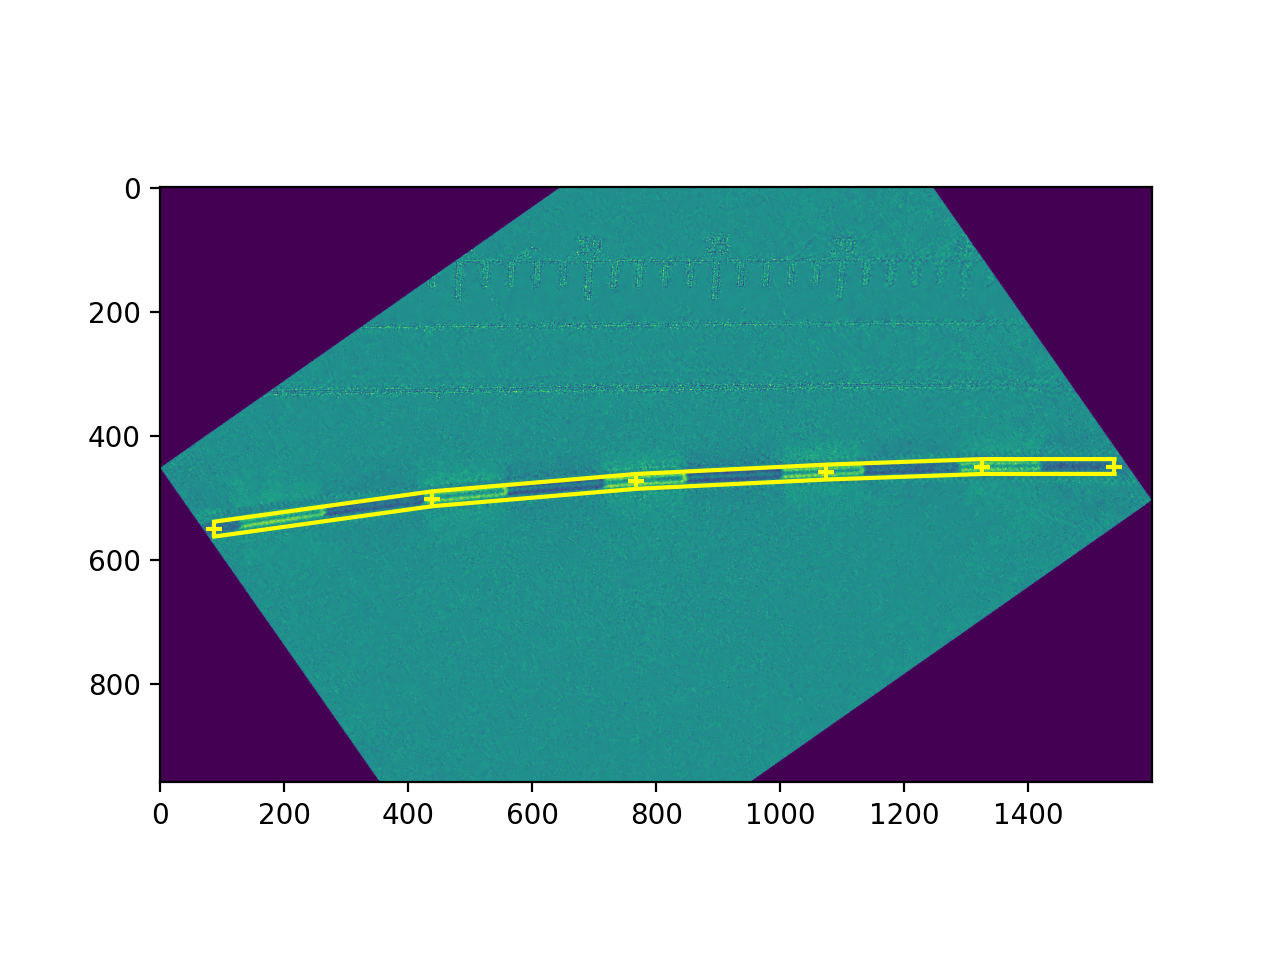

In [28]:
c.find_channel(img)

<IPython.core.display.Javascript object>


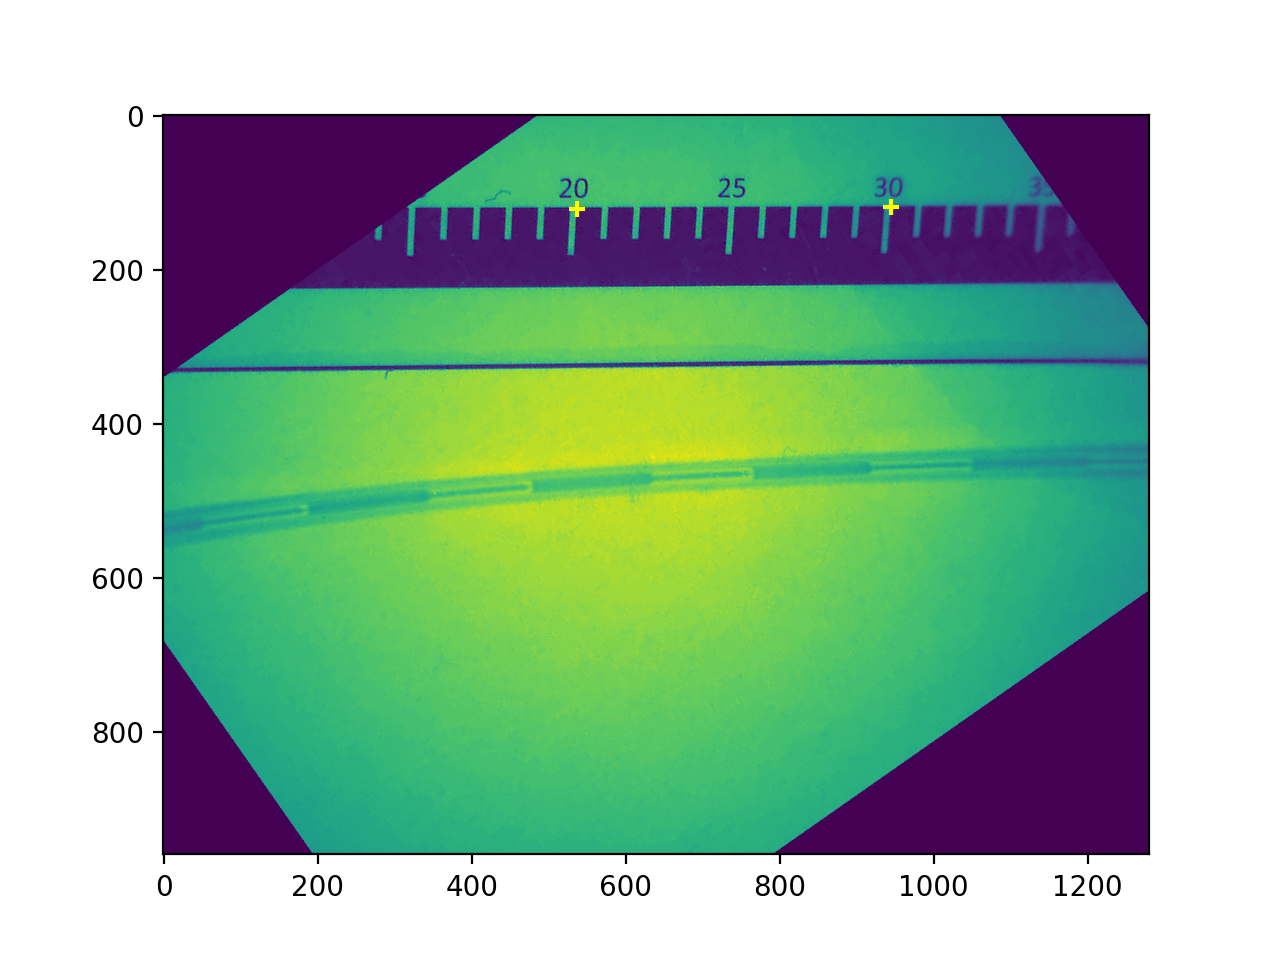

In [29]:
c.calibrate(Image.fromarray(arrays[0][:,:,0]).rotate(35),10)

In [30]:
s, mean, std = c.evaluate(img)

In [23]:
np.asanyarray(img).shape

(960, 1600)

<IPython.core.display.Javascript object>


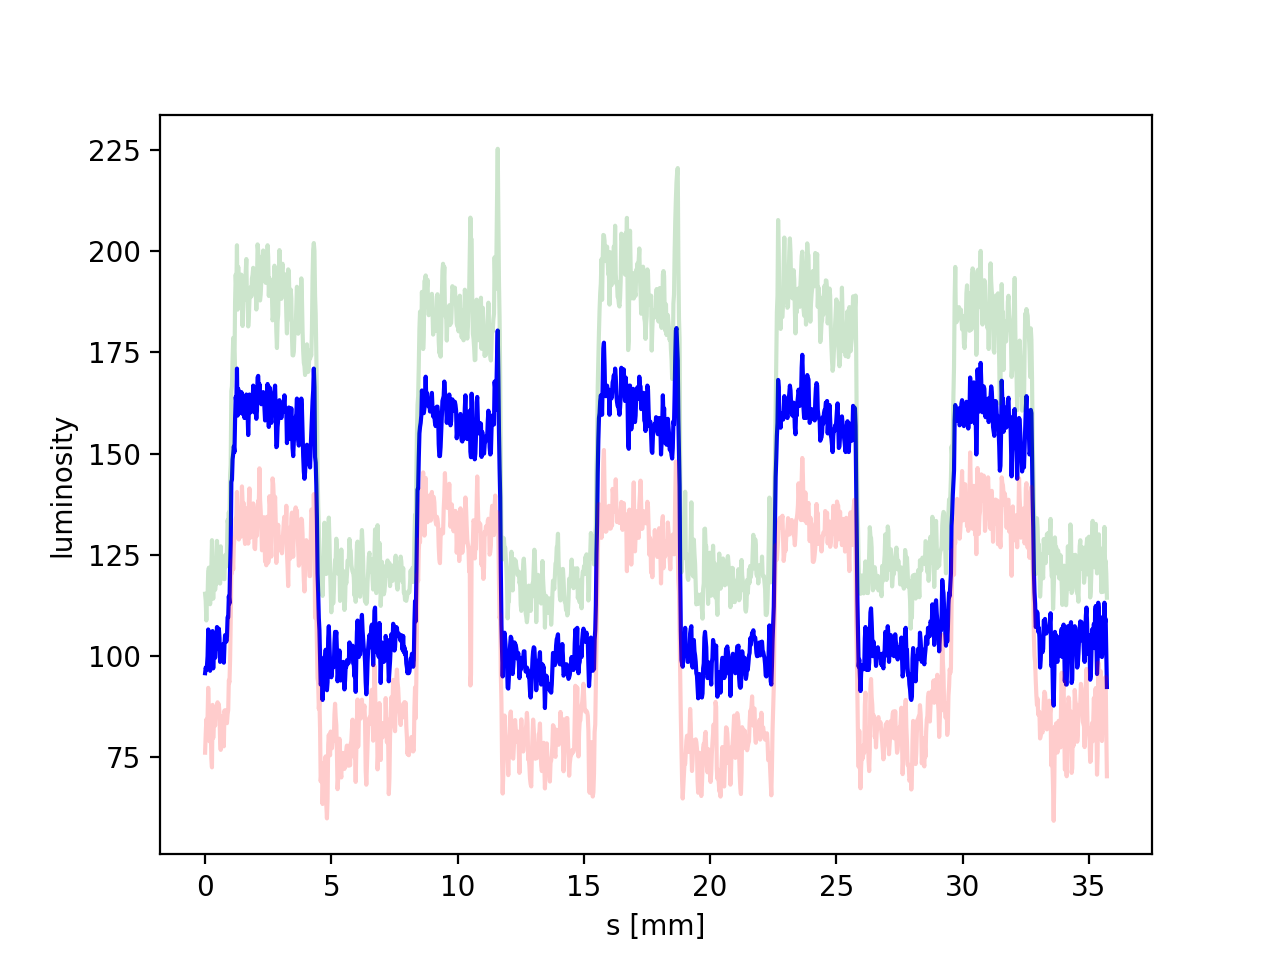

Text(0, 0.5, 'luminosity')

In [40]:
plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

<IPython.core.display.Javascript object>


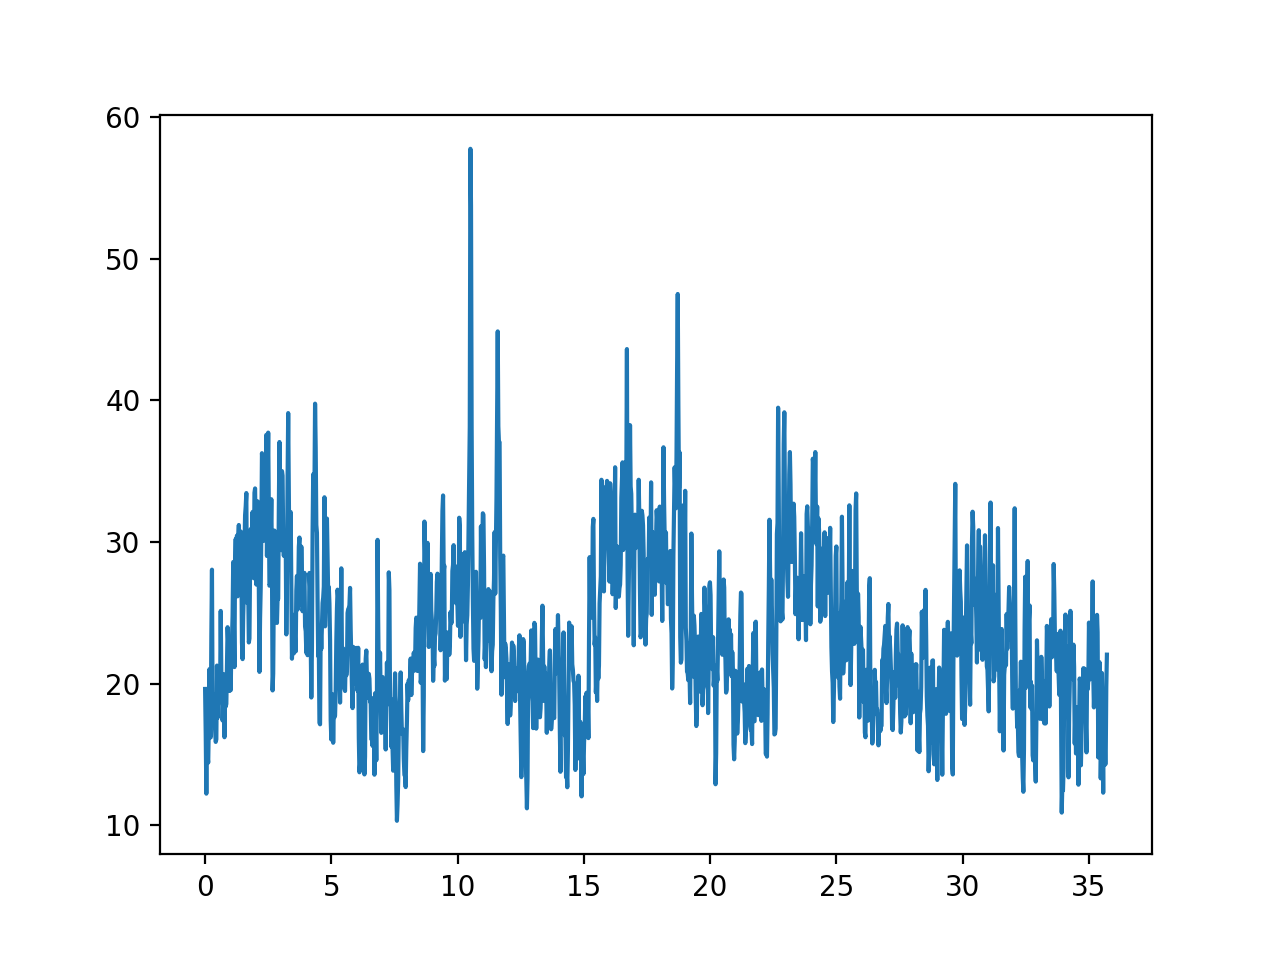

In [38]:
plt.figure()
plt.plot(s,std)

<IPython.core.display.Javascript object>


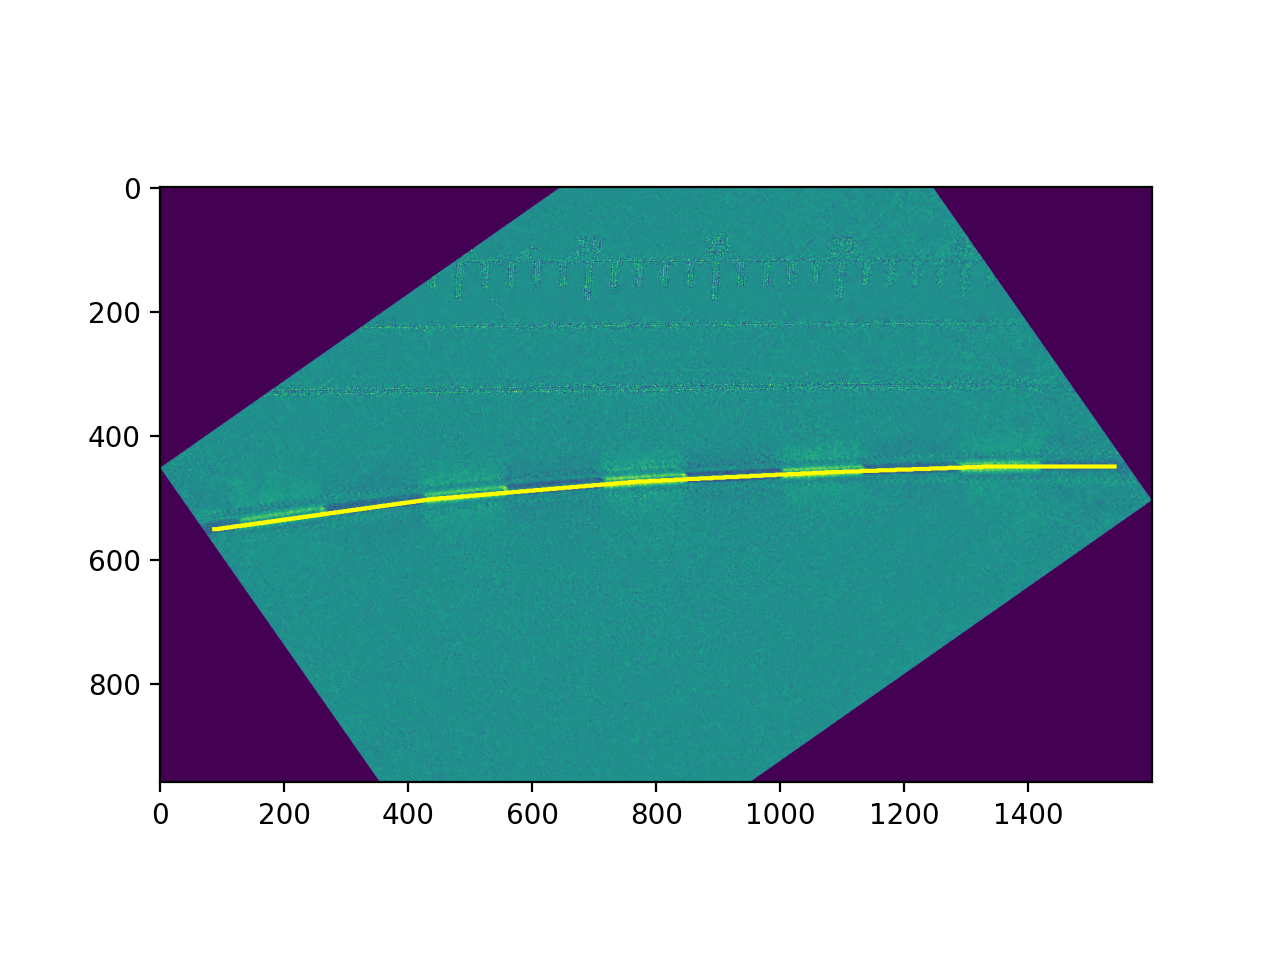

In [31]:
plt.figure()
plt.imshow(img)
plt.plot(np.arange(c.points[0][0], c.points[-1][0] + 1),c.central_ys,color='yellow')

## Trying the fft

<IPython.core.display.Javascript object>


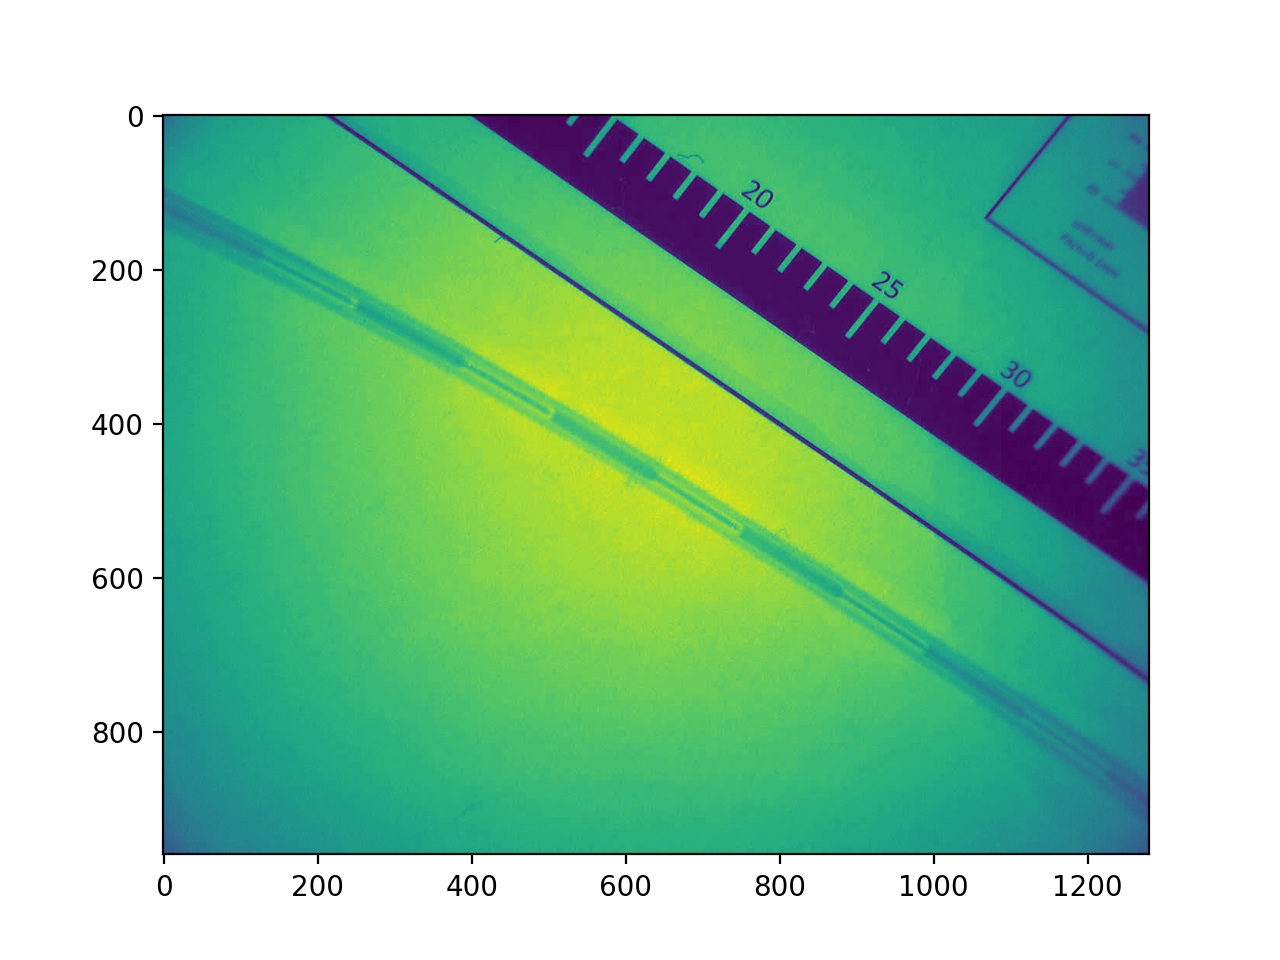

In [21]:
plt.figure()

img2 = arrays[0][:,:,1]
plt.imshow(img2)

In [202]:
img_fft = np.fft.rfft2(img)
img_fft

array([[ 1.35704602e+08+0.00000000e+00j, -4.04967977e+07-1.19340634e+04j,
        -1.32618035e+07-8.39379691e+04j, ...,
        -2.07914603e+03+4.61314581e+03j,  1.22857547e+03-6.06333072e+03j,
         7.94200000e+03+0.00000000e+00j],
       [-2.55873002e+07+1.22520174e+05j, -2.80630993e+06-7.26027905e+04j,
         9.59540886e+06+8.89309432e+04j, ...,
        -3.25864748e+03+4.33546024e+01j,  2.98025921e+02-5.42700265e+03j,
        -4.11597989e+03+1.64389743e+03j],
       [ 1.45621296e+05-2.48261674e+05j,  1.21986877e+07+9.37004903e+04j,
         6.56291575e+06+4.16584157e+04j, ...,
         1.97759276e+02+5.16171842e+03j,  1.16947935e+03+2.94096837e+03j,
         2.33256332e+03+3.00442874e+03j],
       ...,
       [-2.76806991e+06-2.64468561e+05j, -3.89233892e+06+3.43774048e+03j,
         1.42383120e+06-3.71087985e+04j, ...,
        -1.67469196e+03+3.14767310e+03j,  1.54372986e+03+1.16700572e+04j,
        -1.84113410e+03-2.38225206e+02j],
       [ 1.45621296e+05+2.48261674e+05j, -1.

<IPython.core.display.Javascript object>


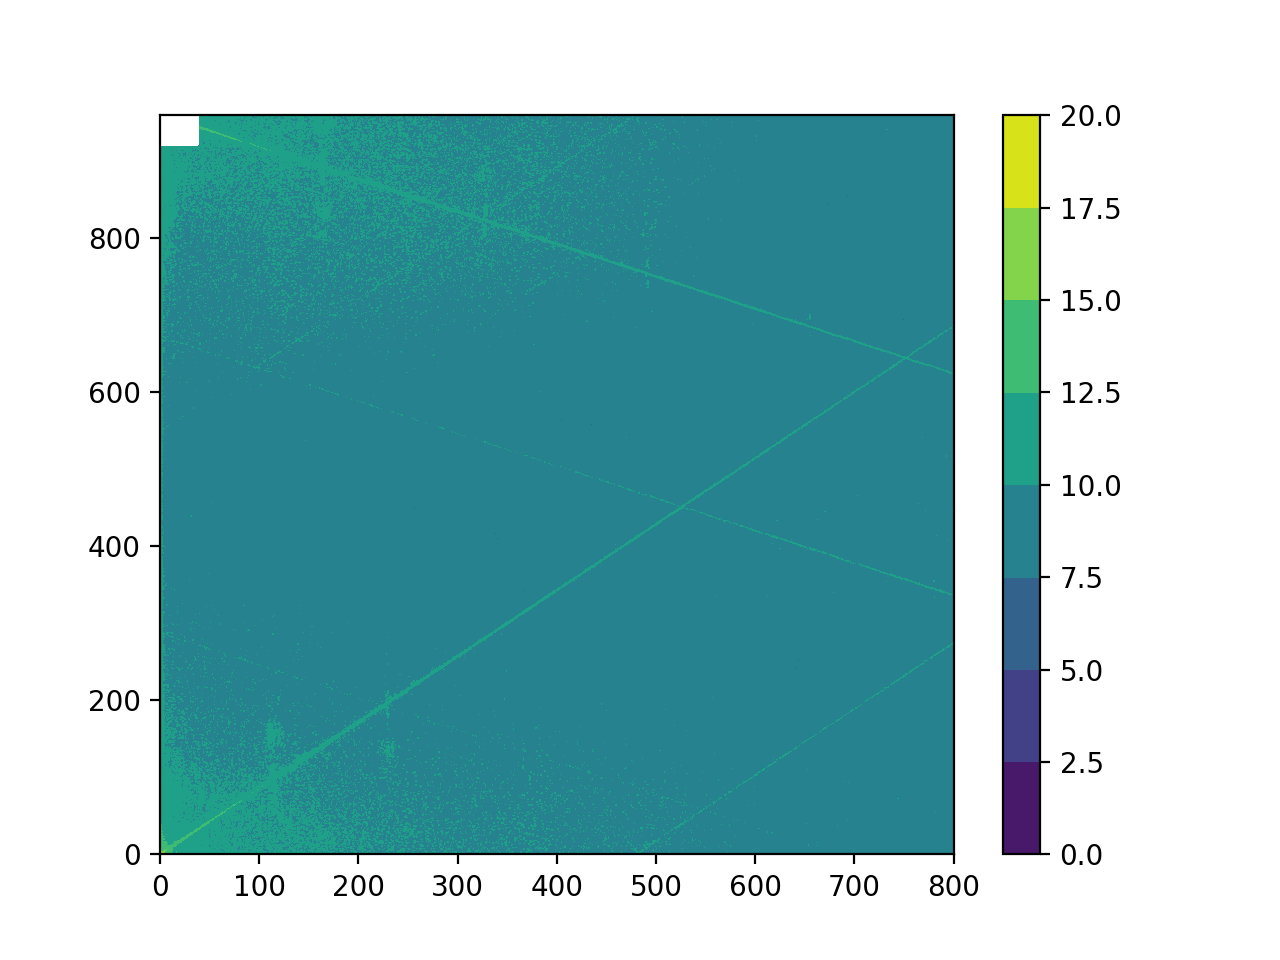

<ipython-input-203-bea80d37b17b>:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(np.abs(img_fft)))


In [203]:
plt.figure()

# img_fft[:40,:40] = 0
img_fft[-40:,:40] = 0

plt.contourf(np.log(np.abs(img_fft)))
plt.colorbar()

In [204]:
img_ifft = np.fft.irfft2(img_fft)

<IPython.core.display.Javascript object>


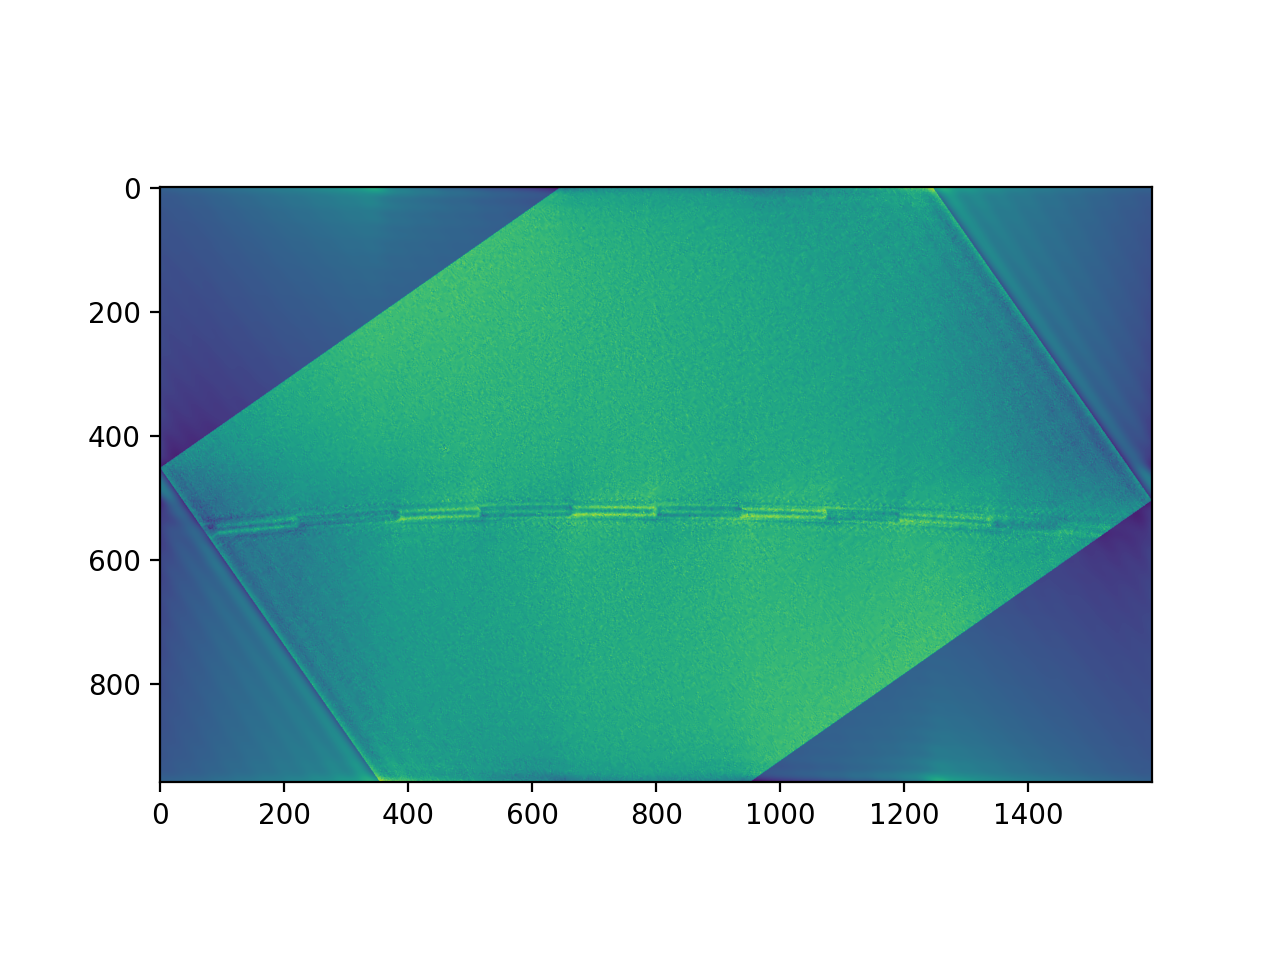

In [205]:
plt.figure()
plt.imshow(img_ifft)

<IPython.core.display.Javascript object>


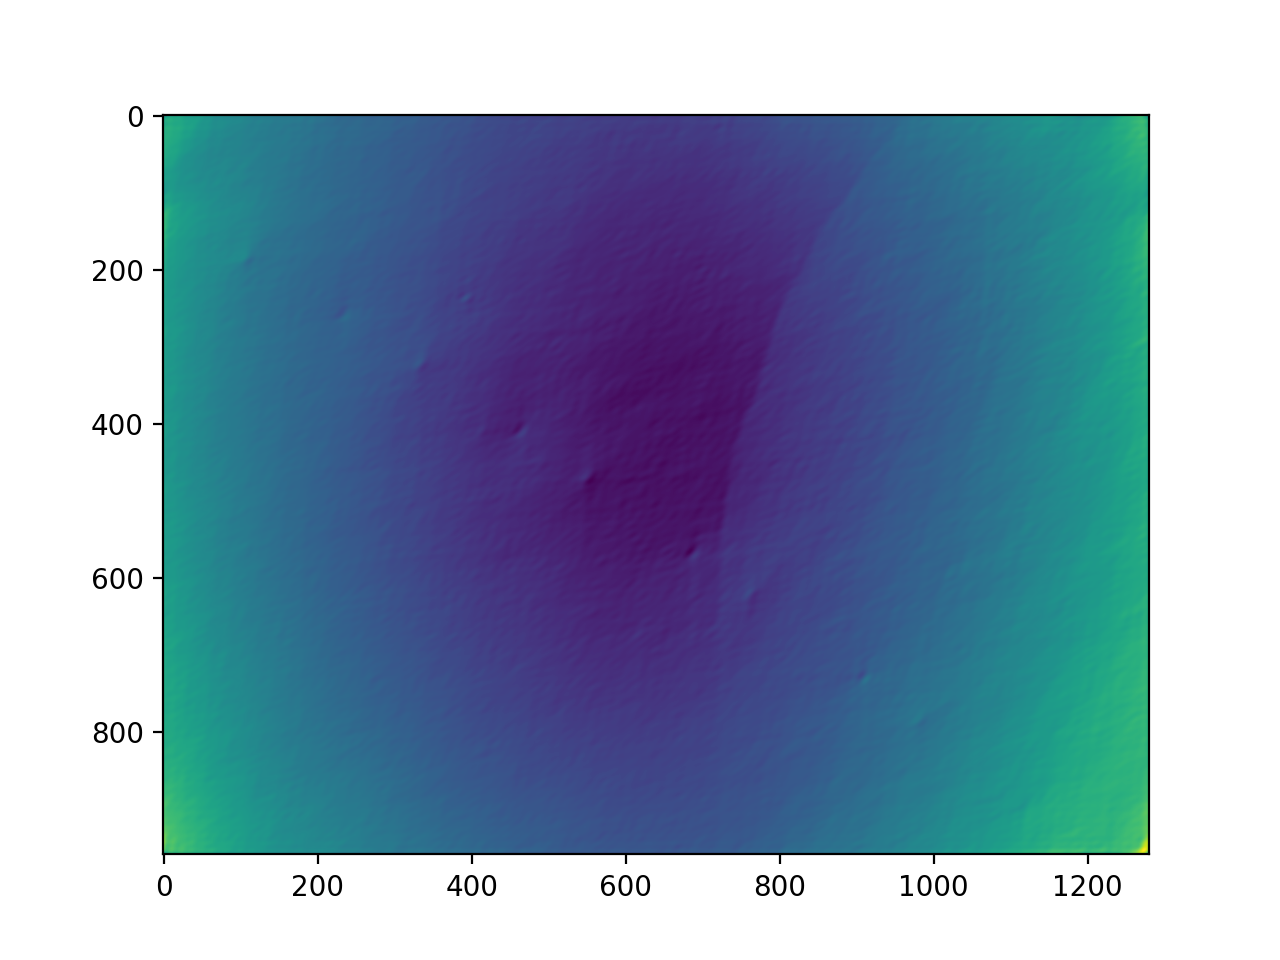

In [177]:
plt.figure()
plt.imshow(img_ifft - img2)